In [2]:
!pip install opencv-python-headless scikit-learn grad-cam -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os, json, math, zipfile
from pathlib import Path
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import timm
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import roc_curve, auc

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 224

_IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device, dtype=torch.float32)
_IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=device, dtype=torch.float32)

def _renorm(x01):
    return (x01 - _IMAGENET_MEAN.view(1,3,1,1)) / _IMAGENET_STD.view(1,3,1,1)

def _denorm(x):
    mean = _IMAGENET_MEAN.view(1,3,1,1).to(x.device)
    std = _IMAGENET_STD.view(1,3,1,1).to(x.device)
    return (x * std) + mean

print("Device:", device)

Device: cuda


In [4]:
class EfficientViT(nn.Module):
    def __init__(
        self,
        num_classes: int = 2,
        backbone_name: str = "efficientnet_b0",
        transformer_layers: int = 4,
        transformer_heads: int = 4,
        dropout: float = 0.1,
        grid_size: int = 7,
    ):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0, global_pool="")
        self.feature_dim = getattr(self.backbone, "num_features", 1280)
        self.grid_size = grid_size

        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.feature_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + grid_size * grid_size, self.feature_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=self.feature_dim,
            nhead=transformer_heads,
            dim_feedforward=self.feature_dim * 4,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=transformer_layers)
        self.pre_ln = nn.LayerNorm(self.feature_dim)

        self.head = nn.Sequential(
            nn.LayerNorm(self.feature_dim),
            nn.Linear(self.feature_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes),
        )

    @torch.no_grad()
    def _interpolate_pos_enc(self, tokens: torch.Tensor, H: int, W: int) -> torch.Tensor:
        B, N, C = tokens.shape
        if H * W == self.grid_size * self.grid_size:
            return self.pos_embed[:, : N, :]
        cls_pe, grid_pe = self.pos_embed[:, :1, :], self.pos_embed[:, 1:, :]
        grid_pe = grid_pe.view(1, self.grid_size, self.grid_size, C).permute(0, 3, 1, 2)
        grid_pe = F.interpolate(grid_pe, size=(H, W), mode="bicubic", align_corners=False)
        grid_pe = grid_pe.permute(0, 2, 3, 1).reshape(1, H * W, C)
        return torch.cat([cls_pe, grid_pe], dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat_map = self.backbone.forward_features(x)
        B, C, H, W = feat_map.shape
        tokens = feat_map.flatten(2).transpose(1, 2)
        cls = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat([cls, tokens], dim=1)
        tokens = tokens + self._interpolate_pos_enc(tokens, H, W)
        tokens = self.pre_ln(tokens)
        tokens = self.transformer(tokens)
        logits = self.head(tokens[:, 0, :])
        return logits


In [10]:
ZIP_PATH = '/content/phase4_artifacts_full (4).zip'
with open('/content/phase4_artifacts_full (4).zip', "rb") as f:
    head = f.read(4)
print(head)

BUNDLE = "/content/phase4_bundle"
if ZIP_PATH and os.path.exists(ZIP_PATH):
    os.makedirs(BUNDLE, exist_ok=True)
    with zipfile.ZipFile(ZIP_PATH) as z:
        z.extractall(BUNDLE)
    if os.path.exists(f"{BUNDLE}/baseline_model.pth"): BASELINE_PTH = f"{BUNDLE}/baseline_model.pth"
    if os.path.exists(f"{BUNDLE}/robust_model.pth"):   ROBUST_PTH   = f"{BUNDLE}/robust_model.pth"
    DATA_ROOT = f"{BUNDLE}/data"

print("Baseline checkpoint:", BASELINE_PTH, os.path.exists(BASELINE_PTH))
print("Robust   checkpoint:", ROBUST_PTH,   os.path.exists(ROBUST_PTH))
print("Data root:", DATA_ROOT, os.path.isdir(DATA_ROOT))

def _strip_module(sd):
    return { (k[7:] if k.startswith("module.") else k): v for k, v in sd.items() }

def load_model(ckpt_path: str) -> nn.Module:
    m = EfficientViT().to(device)
    sd = torch.load(ckpt_path, map_location=device)
    try:    m.load_state_dict(sd, strict=True)
    except: m.load_state_dict(_strip_module(sd), strict=True)
    m.eval()
    return m

eval_baseline = load_model(BASELINE_PTH)
eval_robust   = load_model(ROBUST_PTH)

train_dir = f"{DATA_ROOT}/FFpp_c23_train"
test_dir  = f"{DATA_ROOT}/CelebDF_test"

tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

train_ds = ImageFolder(train_dir, transform=tfms)
test_ds  = ImageFolder(test_dir,  transform=tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

def _fake_index_from_loader(loader) -> int:
    return int(getattr(loader.dataset, "class_to_idx", {"fake":1}).get("fake", 1))

print("Class map train:", train_ds.class_to_idx)
print("Class map test :", test_ds.class_to_idx)


b'PK\x03\x04'
Baseline checkpoint: /content/phase4_bundle/baseline_model.pth True
Robust   checkpoint: /content/phase4_bundle/robust_model.pth True
Data root: /content/phase4_bundle/data True
Class map train: {'fake': 0, 'real': 1}
Class map test : {'fake': 0, 'real': 1}


In [11]:
# Cell 5 — Collect scores and compute metrics (sklearn)
@torch.no_grad()
def collect_scores(model: nn.Module, loader):
    model.eval()
    fake_idx = _fake_index_from_loader(loader)
    labels, scores = [], []
    correct, total = 0, 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)[:, fake_idx]
        pred  = logits.argmax(1)
        correct += (pred == yb).sum().item(); total += yb.numel()

        y_np = yb.detach().cpu().numpy()
        if fake_idx == 0:  # ensure 'fake' is the positive class for ROC
            y_np = 1 - y_np
        labels.append(y_np)
        scores.append(probs.detach().cpu().numpy())

    y = np.concatenate(labels); s = np.concatenate(scores)
    acc = correct / max(1, total)
    return y, s, acc

def metrics_sklearn(y, s, fpr_target=0.01):
    fpr, tpr, _ = roc_curve(y, s)
    roc_auc = float(auc(fpr, tpr))
    tpr_at  = float(np.interp(fpr_target, fpr, tpr))
    return {"fpr": fpr, "tpr": tpr, "roc_auc": roc_auc, "tpr@1%fpr": tpr_at}

def evaluate_split(model, loader, name):
    y, s, acc = collect_scores(model, loader)
    m = metrics_sklearn(y, s, 0.01)
    print(f"{name:18s} | ACC={acc:.4f} | AUC={m['roc_auc']:.4f} | TPR@1%FPR={m['tpr@1%fpr']:.4f}")
    return {"name": name, "acc": acc, **m, "labels": y, "scores": s}

res_celeb_base = evaluate_split(eval_baseline, test_loader,  "CelebDF • baseline")
res_ffpp_base  = evaluate_split(eval_baseline, train_loader, "FF++   • baseline")
res_celeb_rob  = evaluate_split(eval_robust,   test_loader,  "CelebDF • robust")
res_ffpp_rob   = evaluate_split(eval_robust,   train_loader, "FF++   • robust")


CelebDF • baseline | ACC=0.6241 | AUC=0.6782 | TPR@1%FPR=0.0140
FF++   • baseline  | ACC=0.9994 | AUC=1.0000 | TPR@1%FPR=1.0000
CelebDF • robust   | ACC=0.6167 | AUC=0.6757 | TPR@1%FPR=0.0120
FF++   • robust    | ACC=0.9983 | AUC=1.0000 | TPR@1%FPR=1.0000


In [12]:
# Cell 6 — Save summary table
OUT_DIR = "/content/phase4_2_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

rows = []
for r in [res_celeb_base, res_ffpp_base, res_celeb_rob, res_ffpp_rob]:
    rows.append({"name": r["name"], "acc": r["acc"], "roc_auc": r["roc_auc"], "tpr@1%fpr": r["tpr@1%fpr"]})
df = pd.DataFrame(rows)
csv_path = f"{OUT_DIR}/metrics_summary.csv"
df.to_csv(csv_path, index=False)
df


,name,acc,roc_auc,tpr@1%fpr
0,CelebDF • baseline,0.624140,0.678174,0.014
1,FF++ • baseline,0.999435,0.999997,1.000
2,CelebDF • robust,0.616728,0.675695,0.012
3,FF++ • robust,0.998306,0.999999,1.000


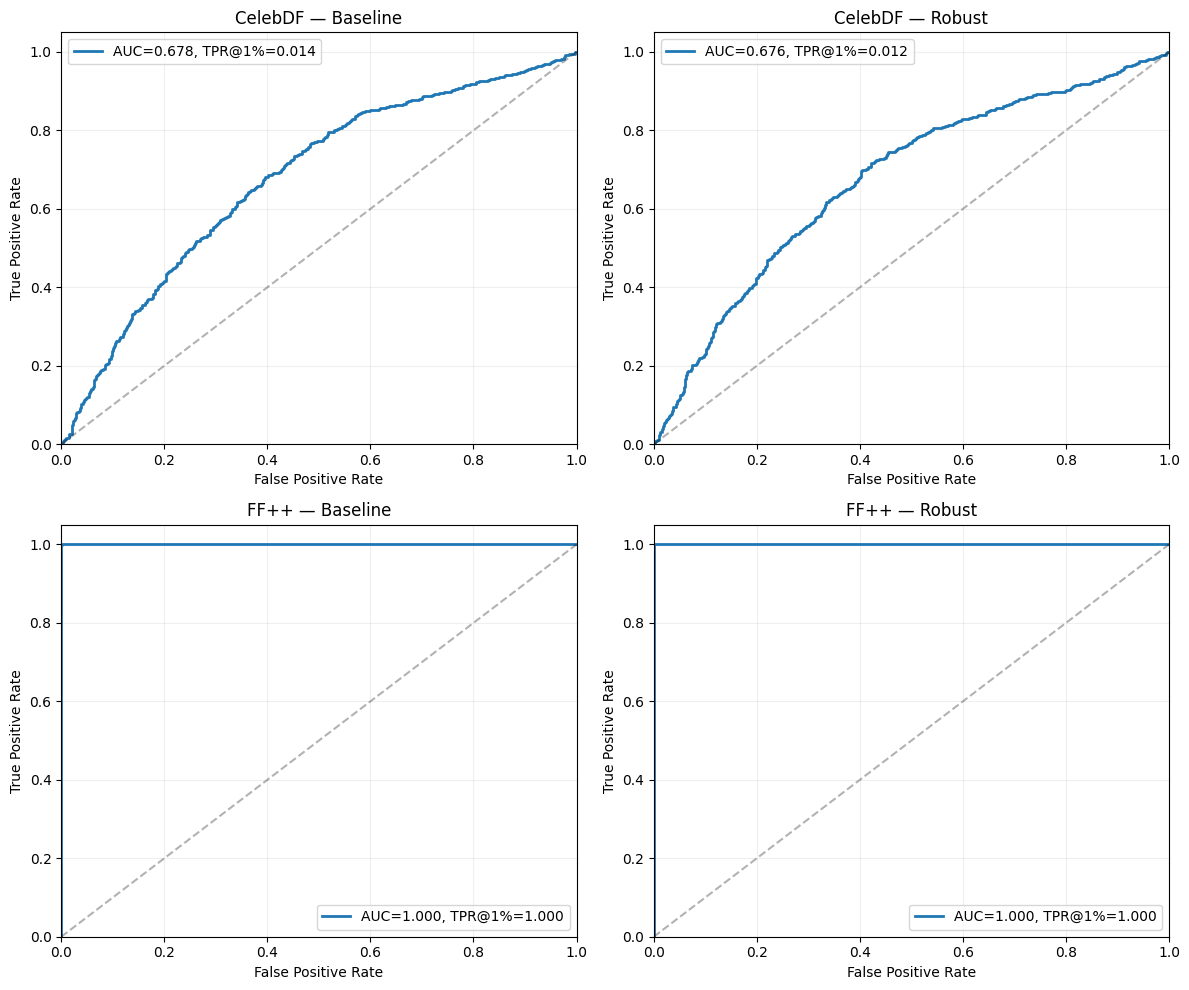

Saved: /content/phase4_2_outputs/metrics_summary.csv and /content/phase4_2_outputs/roc_panels.png


In [13]:
# Cell 7 — Matplotlib ROC plots (4 panels)
plt.figure(figsize=(12,10))

def plot_one(ax, title, res):
    fpr, tpr = res["fpr"], res["tpr"]
    ax.plot(fpr, tpr, lw=2, label=f"AUC={res['roc_auc']:.3f}, TPR@1%={res['tpr@1%fpr']:.3f}")
    ax.plot([0,1],[0,1], 'k--', alpha=0.3)
    ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title); ax.grid(True, alpha=0.2); ax.legend()

ax = plt.subplot(2,2,1); plot_one(ax, "CelebDF — Baseline", res_celeb_base)
ax = plt.subplot(2,2,2); plot_one(ax, "CelebDF — Robust",   res_celeb_rob)
ax = plt.subplot(2,2,3); plot_one(ax, "FF++ — Baseline",    res_ffpp_base)
ax = plt.subplot(2,2,4); plot_one(ax, "FF++ — Robust",      res_ffpp_rob)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/roc_panels.png", dpi=150)
plt.show()

print("Saved:", csv_path, "and", f"{OUT_DIR}/roc_panels.png")


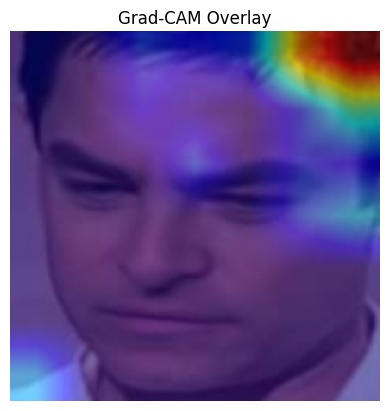

In [16]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np
import matplotlib.pyplot as plt

eval_baseline.eval()

target_layers = [eval_baseline.backbone.conv_head]

fake_idx = train_ds.class_to_idx['fake']

cam = GradCAM(model=eval_baseline, target_layers=target_layers)

img_tensor, label = test_ds[0]

x_norm = img_tensor.unsqueeze(0).to(device)

img_np = _denorm(x_norm.cpu()).clamp(0, 1)[0].permute(1, 2, 0).numpy()


grayscale = cam(input_tensor=x_norm, targets=[ClassifierOutputTarget(fake_idx)])
overlay = show_cam_on_image(img_np, grayscale[0], use_rgb=True, image_weight=0.45)

plt.imshow(overlay)
plt.axis('off')
plt.title('Grad-CAM Overlay')
plt.show()

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np, os, cv2, torch

def _get_fake_idx(ds_or_loader):
    if hasattr(ds_or_loader, "dataset"):
        mapping = getattr(ds_or_loader.dataset, "class_to_idx", {"fake": 1})
    else:
        mapping = getattr(ds_or_loader, "class_to_idx", {"fake": 1})
    return int(mapping.get("fake", 1))

def _float_rgb_from_norm(img_norm_bchw):
    x01 = _denorm(img_norm_bchw).clamp(0, 1)[0].permute(1, 2, 0).detach().cpu().numpy()
    return x01

def _find_target_layers(model):
    """
    Prefer EfficientNet conv_head; if unavailable, fall back to the last Conv2d
    found inside the backbone.
    """
    bb = getattr(model, "backbone", model)
    primary = getattr(bb, "conv_head", None)

    fallback = None
    last_conv = None
    for m in bb.modules():
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
    if last_conv is not None and last_conv is not primary:
        fallback = last_conv

    if primary is None and last_conv is None:
        raise RuntimeError("No suitable Conv2d layer found for Grad-CAM.")

    return primary if primary is not None else last_conv, fallback

def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def _overlay_or_fallback(cam_primary, cam_fallback, x_norm, target_idx, img_rgb01,
                         contrast_thresh=0.02, image_weight=0.45):
    g = cam_primary(input_tensor=x_norm, targets=[ClassifierOutputTarget(int(target_idx))])[0]
    contr = float(g.max() - g.min())
    if contr < contrast_thresh and cam_fallback is not None:
        g2 = cam_fallback(input_tensor=x_norm, targets=[ClassifierOutputTarget(int(target_idx))])[0]
        g, contr = (g2, float(g2.max() - g2.min())) if (g2.max() - g2.min()) > (g.max() - g.min()) else (g, contr)
    overlay = show_cam_on_image(img_rgb01, g, use_rgb=True, image_weight=image_weight)
    return overlay

eval_baseline.eval()
if 'eval_robust' in globals() and isinstance(eval_robust, torch.nn.Module):
    eval_robust.eval()

base_primary, base_fallback = _find_target_layers(eval_baseline)
rob_primary,  rob_fallback  = (None, None)
if 'eval_robust' in globals() and isinstance(eval_robust, torch.nn.Module):
    rob_primary, rob_fallback = _find_target_layers(eval_robust)

cam_base_primary   = GradCAM(model=eval_baseline, target_layers=[base_primary])
cam_base_fallback  = GradCAM(model=eval_baseline, target_layers=[base_fallback]) if base_fallback is not None else None

cam_rob_primary, cam_rob_fallback = None, None
if rob_primary is not None:
    cam_rob_primary  = GradCAM(model=eval_robust,   target_layers=[rob_primary])
    cam_rob_fallback = GradCAM(model=eval_robust,   target_layers=[rob_fallback]) if rob_fallback is not None else None

if 'OUT_DIR' not in globals():
    OUT_DIR = "/content"
save_dir = _ensure_dir(f"{OUT_DIR}/gradcam")

fake_idx_test = _get_fake_idx(test_ds) if 'test_ds' in globals() else _get_fake_idx(test_loader)

saved = 0
limit = 12
for xb, yb in test_loader:
    xb = xb.to(device, non_blocking=True)
    b = xb.size(0)


    for i in range(min(b, limit - saved)):
        img01 = _float_rgb_from_norm(xb[i:i+1])
        ov = _overlay_or_fallback(cam_base_primary, cam_base_fallback,
                                  xb[i:i+1], fake_idx_test, img01,
                                  contrast_thresh=0.02, image_weight=0.45)
        cv2.imwrite(f"{save_dir}/celeb_base_{saved+i:03d}.png",
                    cv2.cvtColor(ov, cv2.COLOR_RGB2BGR))

    if cam_rob_primary is not None:
        for i in range(min(b, limit - saved)):
            img01 = _float_rgb_from_norm(xb[i:i+1])
            ov = _overlay_or_fallback(cam_rob_primary, cam_rob_fallback,
                                      xb[i:i+1], fake_idx_test, img01,
                                      contrast_thresh=0.02, image_weight=0.45)
            cv2.imwrite(f"{save_dir}/celeb_rob_{saved+i:03d}.png",
                        cv2.cvtColor(ov, cv2.COLOR_RGB2BGR))

    saved += b
    if saved >= limit:
        break

print("Grad-CAM images saved to:", save_dir)


Grad-CAM images saved to: /content/phase4_2_outputs/gradcam


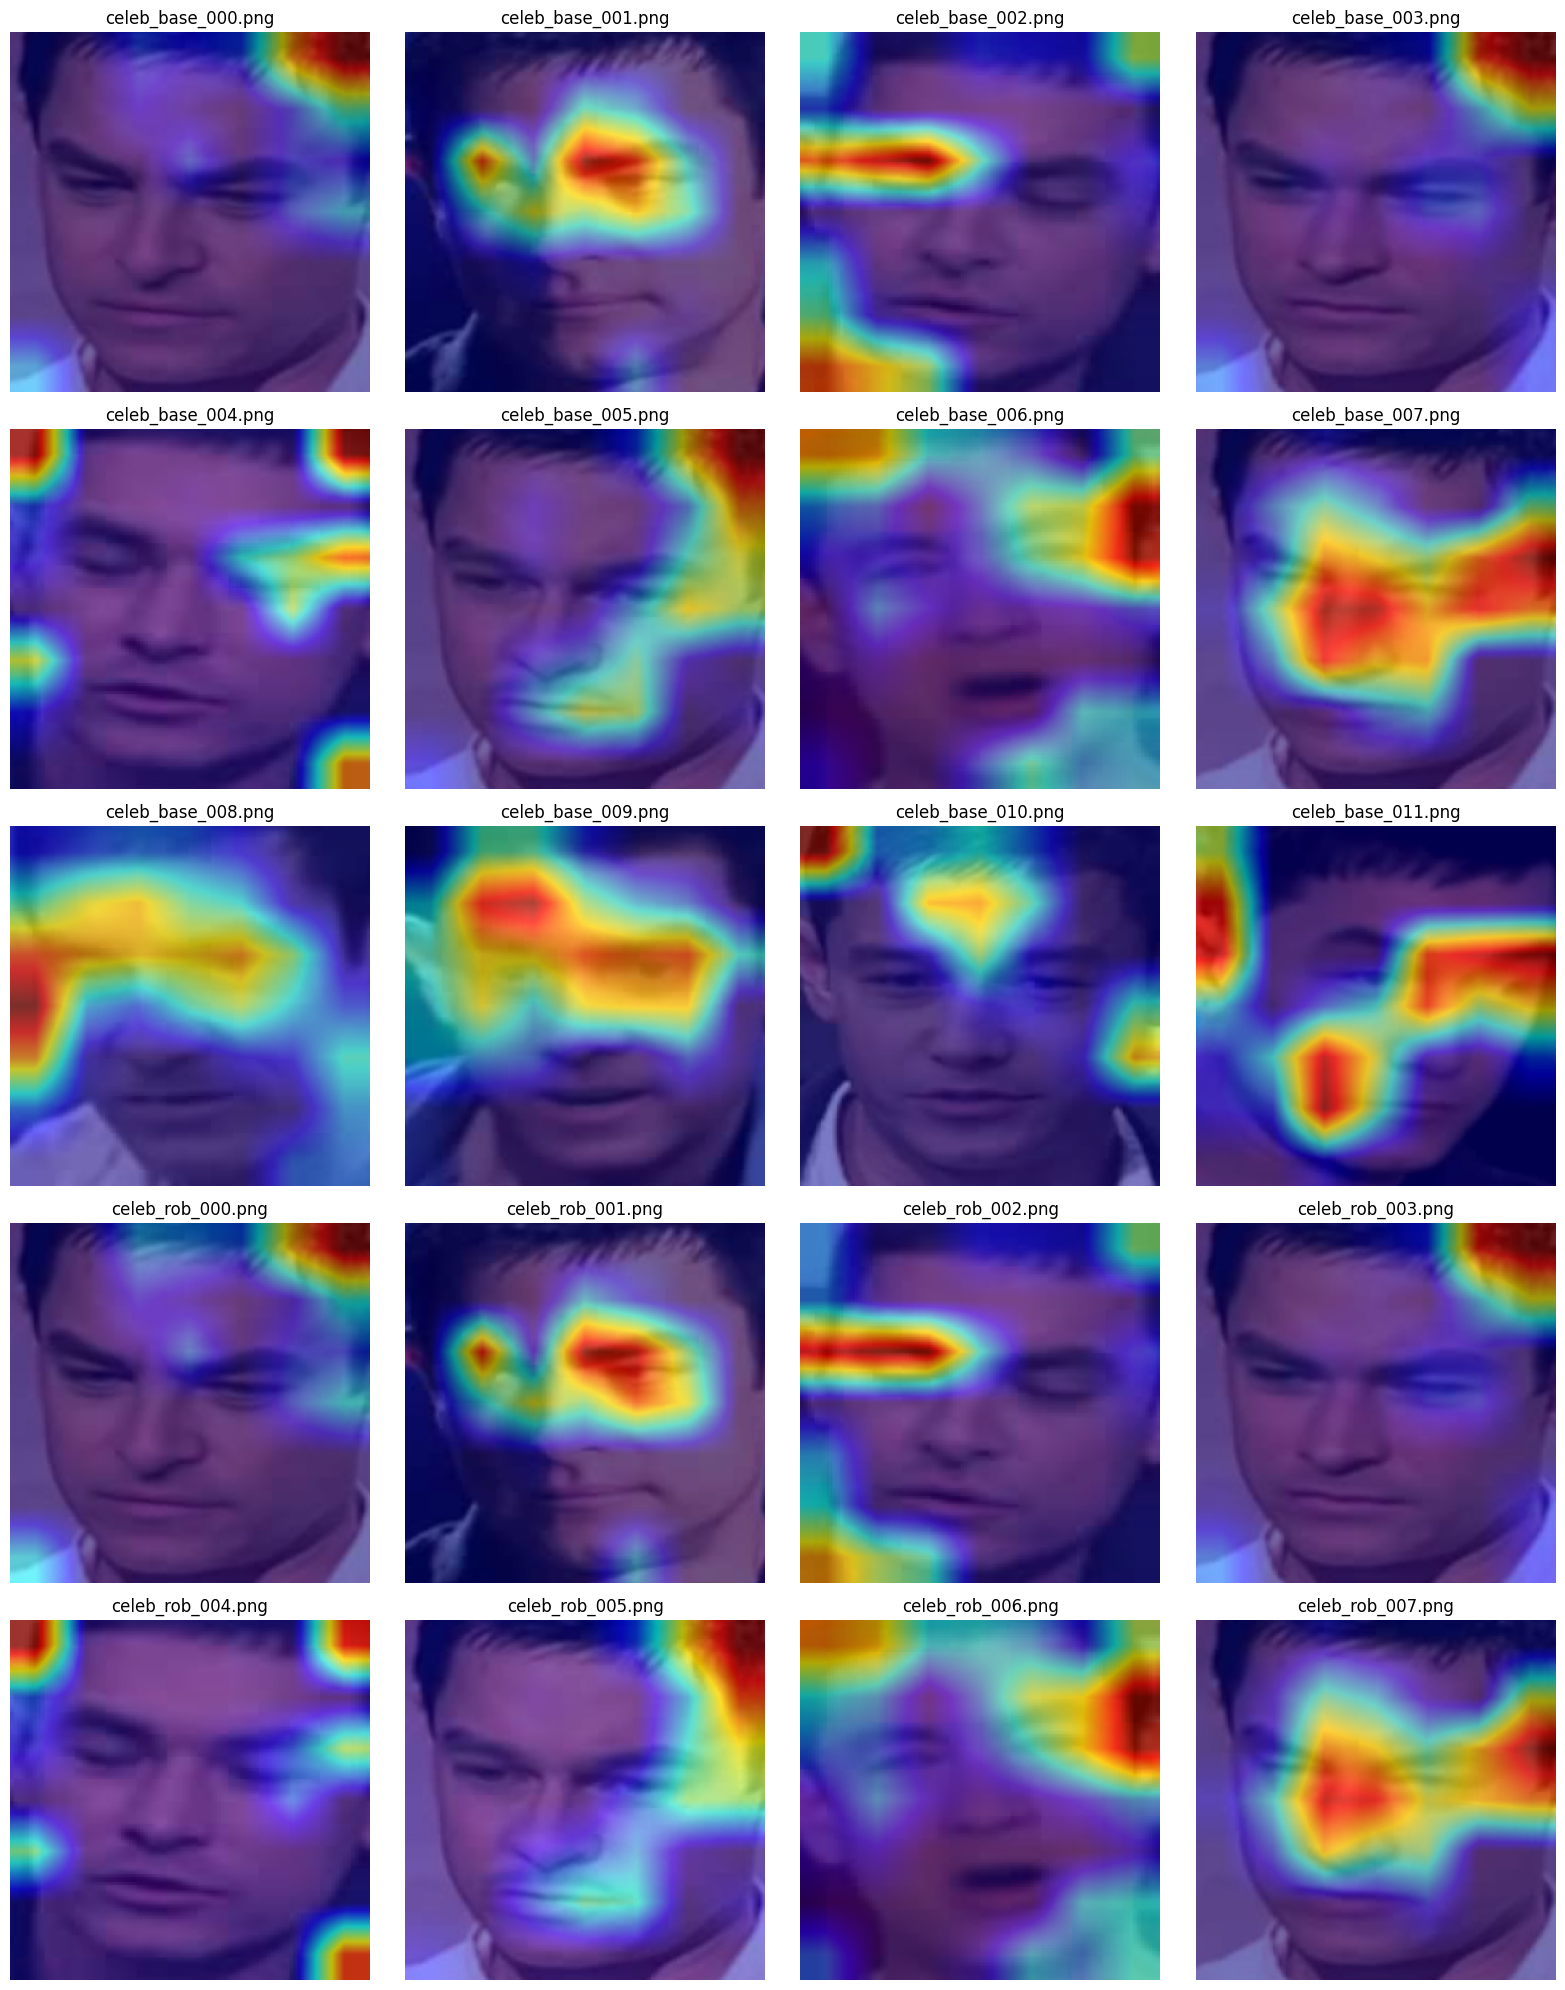

In [18]:
import glob
imgs = sorted(glob.glob(f"{OUT_DIR}/gradcam/*.png"))[:20]
n = len(imgs)
cols = 4
rows = (n + cols - 1) // cols
plt.figure(figsize=(4*cols, 4*rows))
for i, p in enumerate(imgs):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img); ax.set_title(Path(p).name); ax.axis("off")
plt.tight_layout()
plt.show()


In [19]:
ZIP_OUT = "/content/phase4_2_outputs.zip"
with zipfile.ZipFile(ZIP_OUT, "w", zipfile.ZIP_DEFLATED) as z:
    for p in Path(OUT_DIR).rglob("*"):
        if p.is_file():
            z.write(p, p.relative_to(OUT_DIR))
print("Zipped:", ZIP_OUT)


Zipped: /content/phase4_2_outputs.zip
